In [2]:
import numpy as np
import pandas as pd

In [3]:
df_weekday = pd.read_csv('../../data/bike_rental_history/processed_30min_aggregated/2023_processed_weekday_agg.csv')

# create undirected route for the newman method
df_weekday.loc[:,'route_undirect'] = df_weekday.loc[:,['origin_station_id', 'desti_station_id']].apply(lambda x: f'{sorted(x)[0]}~{sorted(x)[1]}', axis=1)
df_weekday_undirected = df_weekday.groupby('route_undirect').agg({'count':'sum'}).reset_index()
df_weekday_undirected.loc[:,'origin_id'] = df_weekday_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[0])
df_weekday_undirected.loc[:,'desti_id'] = df_weekday_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[1])
df_weekday_undirected = df_weekday_undirected.drop(columns=['route_undirect'])

## the travel between same station is not considered    
df_weekday_undirected = df_weekday_undirected.loc[df_weekday_undirected.loc[:,'origin_id'] != df_weekday_undirected.loc[:,'desti_id']]
df_weekday_undirected

,count,origin_id,desti_id
1,7,ST-1000,ST-1005
2,6,ST-1000,ST-1523
3,6,ST-1000,ST-1731
4,3,ST-1000,ST-1964
5,21,ST-1000,ST-1996
...,...,...,...
30563,57,ST-988,ST-99
30565,6,ST-98,ST-984
30566,33,ST-98,ST-987
30567,67,ST-98,ST-99


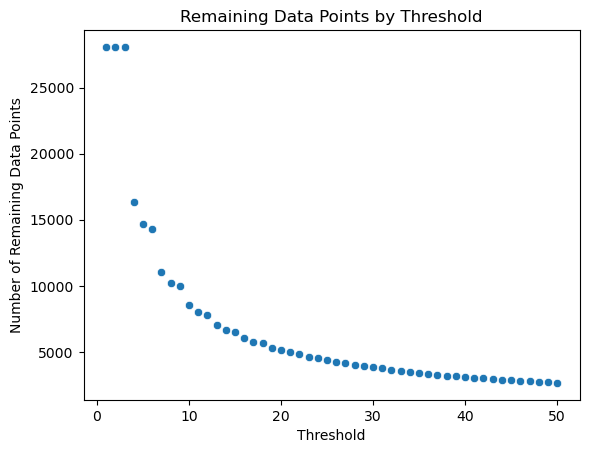

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

thresholds = range(1, 51)
remaining_data = []

for threshold in thresholds:
    filtered_df = df_weekday_undirected[df_weekday_undirected['count'] >= threshold]
    remaining_data.append(len(filtered_df))

sns.scatterplot(x=thresholds, y=remaining_data)
plt.xlabel('Threshold')
plt.ylabel('Number of Remaining Data Points')
plt.title('Remaining Data Points by Threshold')
plt.show()

In [ ]:
import networkx as nx
from networkx.algorithms.community import louvain_partitions

G = nx.from_pandas_edgelist(df_weekday_undirected.loc[df_weekday_undirected.loc[:,'count']>6], source='origin_id', target='desti_id', edge_attr='count')
partition = list(louvain_partitions(G, weight='count', resolution=1))


Community 1: 70 stations
Community 2: 6 stations
Community 3: 44 stations
Community 4: 6 stations
Community 5: 29 stations
Community 6: 10 stations
Community 7: 43 stations
Community 8: 53 stations
Community 9: 38 stations
Community 10: 108 stations
Community 11: 2 stations
Community 12: 100 stations
Community 13: 13 stations
Community 14: 3 stations
Community 15: 10 stations
Community 16: 49 stations
Community 17: 66 stations
Community 18: 2 stations
Community 19: 85 stations
Community 20: 104 stations
Community 21: 141 stations
Community 22: 44 stations
Community 23: 38 stations
Community 24: 91 stations
Community 25: 41 stations
Community 26: 90 stations
Community 27: 69 stations
Community 28: 82 stations
Community 29: 179 stations
Community 30: 75 stations
Community 31: 12 stations
Community 32: 59 stations
Community 33: 40 stations
Community 34: 29 stations
Community 35: 98 stations
Community 36: 68 stations
Community 37: 2 stations
Community 38: 54 stations
Community 39: 2 statio

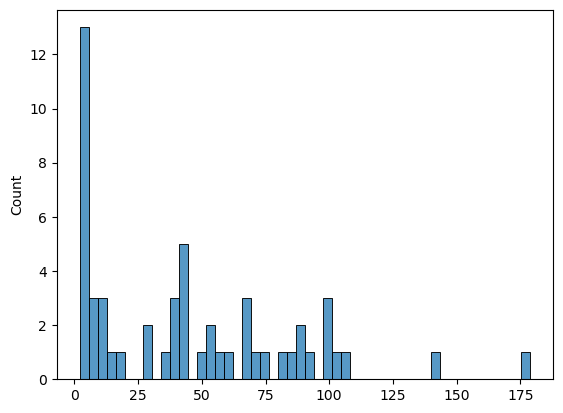

In [46]:
for i, c in enumerate(partition[2]):
    print(f'Community {i+1}: {len(c)} stations')

# draw histogram of community size
community_sizes = [len(c) for c in partition[2]]
sns.histplot(community_sizes, bins=50)

# sort the community by edge count
def community_edge_count(c):
    edge_count = 0
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            if G.has_edge(c[i], c[j]):
                edge_count += G[c[i]][c[j]]['count']
    return edge_count

sorted_partition = sorted([list(c) for c in partition[2]], key=community_edge_count, reverse=True)

In [48]:
for i, c in enumerate(sorted_partition):
    print(f'Community {i+1}: {len(c)} stations, {community_edge_count(c)} edges')

Community 1: 100 stations, 189174 edges
Community 2: 70 stations, 66400 edges
Community 3: 104 stations, 52829 edges
Community 4: 43 stations, 50164 edges
Community 5: 57 stations, 47866 edges
Community 6: 59 stations, 46905 edges
Community 7: 108 stations, 46721 edges
Community 8: 54 stations, 46557 edges
Community 9: 66 stations, 45786 edges
Community 10: 98 stations, 44795 edges
Community 11: 68 stations, 40221 edges
Community 12: 141 stations, 39228 edges
Community 13: 49 stations, 33748 edges
Community 14: 179 stations, 30444 edges
Community 15: 38 stations, 30273 edges
Community 16: 40 stations, 25540 edges
Community 17: 13 stations, 22723 edges
Community 18: 89 stations, 21962 edges
Community 19: 85 stations, 20838 edges
Community 20: 42 stations, 20254 edges
Community 21: 98 stations, 18809 edges
Community 22: 82 stations, 18540 edges
Community 23: 75 stations, 18482 edges
Community 24: 53 stations, 17919 edges
Community 25: 12 stations, 15851 edges
Community 26: 91 stations, 1

In [49]:
for i, c in enumerate(sorted_partition[:5]):
    df_weekday_undirected_tmp = df_weekday_undirected.loc[df_weekday_undirected.loc[:,'origin_id'].isin(c), :]
    df_weekday_undirected_tmp = df_weekday_undirected_tmp.loc[df_weekday_undirected_tmp.loc[:,'desti_id'].isin(c), :]
    df_weekday_undirected_tmp.to_csv(f'../../data/bike_rental_history/communities/weekday/{i}.csv', index=False)

## Weekend

In [51]:
df_weekend = pd.read_csv('../../data/bike_rental_history/processed_30min_aggregated/2023_processed_weekend_agg.csv')

# create undirected route for the newman method
df_weekend.loc[:,'route_undirect'] = df_weekend.loc[:,['origin_station_id', 'desti_station_id']].apply(lambda x: f'{sorted(x)[0]}~{sorted(x)[1]}', axis=1)
df_weekend_undirected = df_weekend.groupby('route_undirect').agg({'count':'sum'}).reset_index()
df_weekend_undirected.loc[:,'origin_id'] = df_weekend_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[0])
df_weekend_undirected.loc[:,'desti_id'] = df_weekend_undirected.loc[:,'route_undirect'].apply(lambda x: x.split('~')[1])
df_weekend_undirected = df_weekend_undirected.drop(columns=['route_undirect'])

## the travel between same station is not considered    
df_weekend_undirected = df_weekend_undirected.loc[df_weekend_undirected.loc[:,'origin_id'] != df_weekend_undirected.loc[:,'desti_id']]
df_weekend_undirected

,count,origin_id,desti_id
1,3,ST-1000,ST-1002
2,11,ST-1000,ST-1005
3,3,ST-1000,ST-1350
4,3,ST-1000,ST-1731
5,10,ST-1000,ST-1995
...,...,...,...
25095,17,ST-987,ST-99
25097,31,ST-988,ST-99
25099,3,ST-98,ST-987
25100,46,ST-98,ST-99


In [52]:
import networkx as nx
from networkx.algorithms.community import louvain_partitions

G = nx.from_pandas_edgelist(df_weekend_undirected.loc[df_weekend_undirected.loc[:,'count']>6], source='origin_id', target='desti_id', edge_attr='count')
partition = list(louvain_partitions(G, weight='count', resolution=1))

# sort the community by edge count
def community_edge_count(c):
    edge_count = 0
    for i in range(len(c)):
        for j in range(i+1, len(c)):
            if G.has_edge(c[i], c[j]):
                edge_count += G[c[i]][c[j]]['count']
    return edge_count

sorted_partition = sorted([list(c) for c in partition[2]], key=community_edge_count, reverse=True)

for i, c in enumerate(sorted_partition[:5]):
    df_weekend_undirected_tmp = df_weekend_undirected.loc[df_weekend_undirected.loc[:,'origin_id'].isin(c), :]
    df_weekend_undirected_tmp = df_weekend_undirected_tmp.loc[df_weekend_undirected_tmp.loc[:,'desti_id'].isin(c), :]
    df_weekend_undirected_tmp.to_csv(f'../../data/bike_rental_history/communities/weekend/{i}.csv', index=False)

In [53]:
for i, c in enumerate(sorted_partition):
    print(f'Community {i+1}: {len(c)} stations, {community_edge_count(c)} edges')

Community 1: 158 stations, 25863 edges
Community 2: 119 stations, 18936 edges
Community 3: 89 stations, 15522 edges
Community 4: 164 stations, 15140 edges
Community 5: 166 stations, 14715 edges
Community 6: 105 stations, 13689 edges
Community 7: 79 stations, 10837 edges
Community 8: 58 stations, 10030 edges
Community 9: 103 stations, 9746 edges
Community 10: 116 stations, 8574 edges
Community 11: 198 stations, 8442 edges
Community 12: 131 stations, 8011 edges
Community 13: 52 stations, 7495 edges
Community 14: 40 stations, 3962 edges
Community 15: 93 stations, 3832 edges
Community 16: 81 stations, 3164 edges
Community 17: 42 stations, 2712 edges
Community 18: 55 stations, 1371 edges
Community 19: 23 stations, 1271 edges
Community 20: 54 stations, 1047 edges
Community 21: 26 stations, 890 edges
Community 22: 13 stations, 600 edges
Community 23: 12 stations, 294 edges
Community 24: 6 stations, 146 edges
Community 25: 5 stations, 50 edges
Community 26: 6 stations, 43 edges
Community 27: 5